In [ ]:
!pip install pandas
!pip install matplotlib
!pip install requests
!pip install python-dotenv

# Import all needed libraries

In [2]:
# For data reading and manipulation
import pandas as pd
import numpy as np
# For data visualization
import matplotlib.pyplot as plt
# For API requests
import requests
# For loading environment variables
from dotenv import load_dotenv
# For accessing environment variables & files
import os

load_dotenv()  # This line brings all environment variables from .env into os.environ
reports_path = "../figures/"

# Load data

In [3]:
path = "../data/input/Sales data.csv"
sales_df = pd.read_csv(path)
sales_df.head()

,order_id,customer_id,product_id,quantity,price,order_date
0,2334,5,40,3,35.60,2022-06-21
1,6228,8,13,7,36.52,2023-03-08
2,7784,9,44,4,46.56,2023-04-22
3,6588,5,26,1,15.87,2022-10-23
4,5910,8,32,10,77.00,2022-10-05


As we can see same product_id may have different prices

In [4]:
sales_df[["product_id", "price"]]

,product_id,price
0,40,35.60
1,13,36.52
2,44,46.56
3,26,15.87
4,32,77.00
...,...,...
995,34,14.44
996,16,61.38
997,18,62.96
998,37,52.89


# Get customers data

In [5]:
customers_url = "https://jsonplaceholder.typicode.com/users"
customers = []
try:
    response = requests.get(customers_url)
    customers = response.json()
except Exception as e:
    print("WARNING: Cannot get customers data dua to the following error:\n", str(e))

print(f"Number of customers: {len(customers)}")
print(customers[:2])

Number of customers: 10
[{'id': 1, 'name': 'Leanne Graham', 'username': 'Bret', 'email': 'Sincere@april.biz', 'address': {'street': 'Kulas Light', 'suite': 'Apt. 556', 'city': 'Gwenborough', 'zipcode': '92998-3874', 'geo': {'lat': '-37.3159', 'lng': '81.1496'}}, 'phone': '1-770-736-8031 x56442', 'website': 'hildegard.org', 'company': {'name': 'Romaguera-Crona', 'catchPhrase': 'Multi-layered client-server neural-net', 'bs': 'harness real-time e-markets'}}, {'id': 2, 'name': 'Ervin Howell', 'username': 'Antonette', 'email': 'Shanna@melissa.tv', 'address': {'street': 'Victor Plains', 'suite': 'Suite 879', 'city': 'Wisokyburgh', 'zipcode': '90566-7771', 'geo': {'lat': '-43.9509', 'lng': '-34.4618'}}, 'phone': '010-692-6593 x09125', 'website': 'anastasia.net', 'company': {'name': 'Deckow-Crist', 'catchPhrase': 'Proactive didactic contingency', 'bs': 'synergize scalable supply-chains'}}]


# Get only needed customers data

In [6]:
# Get the needed data only, if the customer_id in the sales data 
customers_data = [{
    "customer_id": u.get("id", np.nan),
    "name": u.get("name", np.nan),
    "username": u.get("username", np.nan),
    "email": u.get("email", np.nan),
    "lat": u.get("address", {}).get("geo", {}).get("lat", np.nan),
    "lng": u.get("address", {}).get("geo", {}).get("lng", np.nan),
} for u in customers if u.get("id", np.nan) in list(sales_df["customer_id"])]

customers_data[:3]

[{'customer_id': 1,
  'name': 'Leanne Graham',
  'username': 'Bret',
  'email': 'Sincere@april.biz',
  'lat': '-37.3159',
  'lng': '81.1496'},
 {'customer_id': 2,
  'name': 'Ervin Howell',
  'username': 'Antonette',
  'email': 'Shanna@melissa.tv',
  'lat': '-43.9509',
  'lng': '-34.4618'},
 {'customer_id': 3,
  'name': 'Clementine Bauch',
  'username': 'Samantha',
  'email': 'Nathan@yesenia.net',
  'lat': '-68.6102',
  'lng': '-47.0653'}]

# Add weather data to customers data

In [7]:
WEATHER_API_KEY =  os.environ['WEATHER_API_KEY']

weather_url = "https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={API_KEY}"

for u in customers_data:
    customer_id = u["customer_id"]
    lat, lng = u.get("lat", None), u.get("lng", None)
    weather_data = {
        "temp": np.nan,
        "feels_like": np.nan,
        "temp_min": np.nan,
        "temp_max": np.nan,
        "pressure": np.nan,
        "humidity": np.nan,
        "sea_level": np.nan,
        "grnd_level": np.nan
    }
    
    if lat and lng:
        url = weather_url.format(lat=lat, lon=lng, API_KEY=WEATHER_API_KEY)
        
        try:
            response = requests.get(url)
            weather_info = response.json()
        except Exception as e:
            print(f"WARNING: Cannot get weather data for customer_id: {customer_id} with lat={lat} and lng={lng} dua to the following error:\n{str(e)}")

        status = weather_info["cod"]
        if status!= 200:
            print(f"WARNING: Cannot get weather data for customer_id: {customer_id} with lat={lat} and lng={lng} response status code is {status}")
            
        main_info = weather_info.get("main", None)
        weather_cond = weather_info.get("weather", np.nan)

        if main_info:
            weather_data = {
                "temp": main_info.get("temp", np.nan),
                "feels_like": main_info.get("feels_like", np.nan),
                "temp_min": main_info.get("temp_min", np.nan),
                "temp_max": main_info.get("temp_max", np.nan),
                "pressure": main_info.get("pressure", np.nan),
                "humidity": main_info.get("humidity", np.nan),
                "sea_level": main_info.get("sea_level", np.nan),
                "grnd_level": main_info.get("grnd_level", np.nan)
            }
        else:
            print(f"WARNING: Cannot get weather data for customer_id: {customer_id} because: there are no lat and lng information")


        if weather_cond:
            weather_data = {
                "weather_condition": weather_cond[0].get("main", "").lower()
            }
            
    u.update(weather_data)

customers_data[:3]

[{'customer_id': 1,
  'name': 'Leanne Graham',
  'username': 'Bret',
  'email': 'Sincere@april.biz',
  'lat': '-37.3159',
  'lng': '81.1496',
  'weather_condition': 'clouds'},
 {'customer_id': 2,
  'name': 'Ervin Howell',
  'username': 'Antonette',
  'email': 'Shanna@melissa.tv',
  'lat': '-43.9509',
  'lng': '-34.4618',
  'weather_condition': 'clear'},
 {'customer_id': 3,
  'name': 'Clementine Bauch',
  'username': 'Samantha',
  'email': 'Nathan@yesenia.net',
  'lat': '-68.6102',
  'lng': '-47.0653',
  'weather_condition': 'clear'}]

# Convert customers data to df

In [8]:
customers_df = pd.DataFrame.from_dict(customers_data)
customers_df

,customer_id,name,username,email,lat,lng,weather_condition
0,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,clouds
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,-43.9509,-34.4618,clear
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,-68.6102,-47.0653,clear
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,29.4572,-164.2990,clouds
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,-31.8129,62.5342,clear
5,6,Mrs. Dennis Schulist,Leopoldo_Corkery,Karley_Dach@jasper.info,-71.4197,71.7478,clouds
6,7,Kurtis Weissnat,Elwyn.Skiles,Telly.Hoeger@billy.biz,24.8918,21.8984,clouds
7,8,Nicholas Runolfsdottir V,Maxime_Nienow,Sherwood@rosamond.me,-14.3990,-120.7677,clouds
8,9,Glenna Reichert,Delphine,Chaim_McDermott@dana.io,24.6463,-168.8889,rain
9,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,-38.2386,57.2232,clouds


# Merge customers data with sales data based on the customer_id

In [9]:
customer_sales_df = sales_df.merge(customers_df, how='left', on="customer_id")
customer_sales_df.head()

,order_id,customer_id,product_id,quantity,price,order_date,name,username,email,lat,lng,weather_condition
0,2334,5,40,3,35.60,2022-06-21,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,-31.8129,62.5342,clear
1,6228,8,13,7,36.52,2023-03-08,Nicholas Runolfsdottir V,Maxime_Nienow,Sherwood@rosamond.me,-14.3990,-120.7677,clouds
2,7784,9,44,4,46.56,2023-04-22,Glenna Reichert,Delphine,Chaim_McDermott@dana.io,24.6463,-168.8889,rain
3,6588,5,26,1,15.87,2022-10-23,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,-31.8129,62.5342,clear
4,5910,8,32,10,77.00,2022-10-05,Nicholas Runolfsdottir V,Maxime_Nienow,Sherwood@rosamond.me,-14.3990,-120.7677,clouds


# Data analysis

* Calculate total sales amount per customer.
*  Determine the average order quantity per product
* Identify the top-selling products or customers.
* Analyze sales trends over time (e.g., monthly or quarterly sales).
* Include weather data in the analysis (e.g., average sales amount per weather condition))ition)

## Check for data types and Nulls

In [10]:
customer_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           1000 non-null   int64  
 1   customer_id        1000 non-null   int64  
 2   product_id         1000 non-null   int64  
 3   quantity           1000 non-null   int64  
 4   price              1000 non-null   float64
 5   order_date         1000 non-null   object 
 6   name               1000 non-null   object 
 7   username           1000 non-null   object 
 8   email              1000 non-null   object 
 9   lat                1000 non-null   object 
 10  lng                1000 non-null   object 
 11  weather_condition  1000 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 93.9+ KB


All values in all columns are not null and all data types as expected except for order_date

# Convert order_date to datetime

In [11]:
customer_sales_df["order_date"] = pd.to_datetime(customer_sales_df["order_date"])
customer_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           1000 non-null   int64         
 1   customer_id        1000 non-null   int64         
 2   product_id         1000 non-null   int64         
 3   quantity           1000 non-null   int64         
 4   price              1000 non-null   float64       
 5   order_date         1000 non-null   datetime64[ns]
 6   name               1000 non-null   object        
 7   username           1000 non-null   object        
 8   email              1000 non-null   object        
 9   lat                1000 non-null   object        
 10  lng                1000 non-null   object        
 11  weather_condition  1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 93.9+ KB


## Calculate total sales amount per customer.

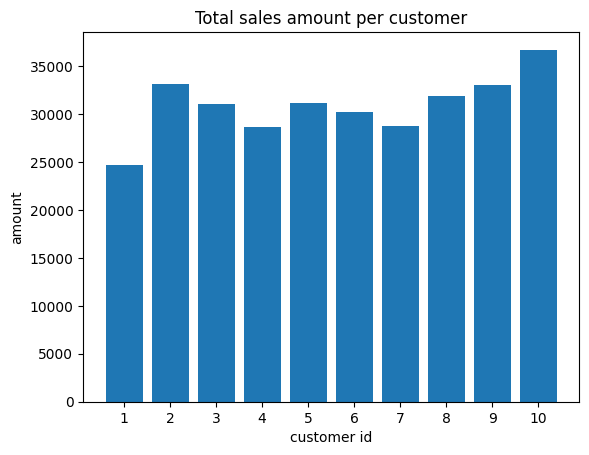

In [12]:
# Calculate amount to get total sales per customer
# amount = quantity of product * price of product
customer_sales_df["amount"] = customer_sales_df["quantity"] * customer_sales_df["price"]
sales_per_customer = customer_sales_df.groupby("customer_id")["amount"].sum()

plt.bar(sales_per_customer.index.astype(str), sales_per_customer)  # Plot the chart
plt.xlabel('customer id')
plt.ylabel('amount')
plt.title('Total sales amount per customer')
plt.savefig(reports_path + "Total sales amount per customer.png") # save as png
plt.show()  # display

## Determine the average order quantity per product

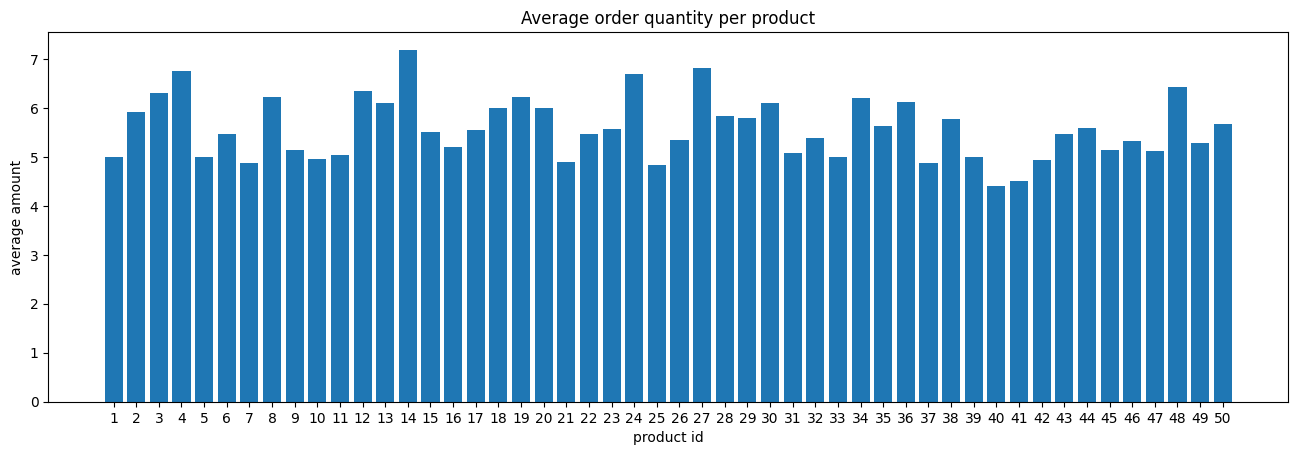

In [13]:
avg_quantity_per_prod = customer_sales_df.groupby("product_id")["quantity"].mean()

plt.figure().set_figwidth(16)
plt.bar(avg_quantity_per_prod.index.astype(str), avg_quantity_per_prod)  # Plot the chart
plt.xlabel('product id')
plt.ylabel('average amount')
plt.title('Average order quantity per product')
plt.savefig(reports_path + "Average order quantity per product") # save as png
plt.show()  # display

## Identify the top-selling products or customers.

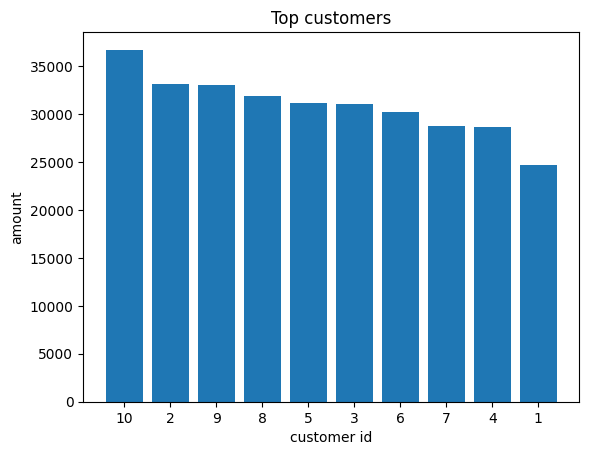

top customer_id is 10


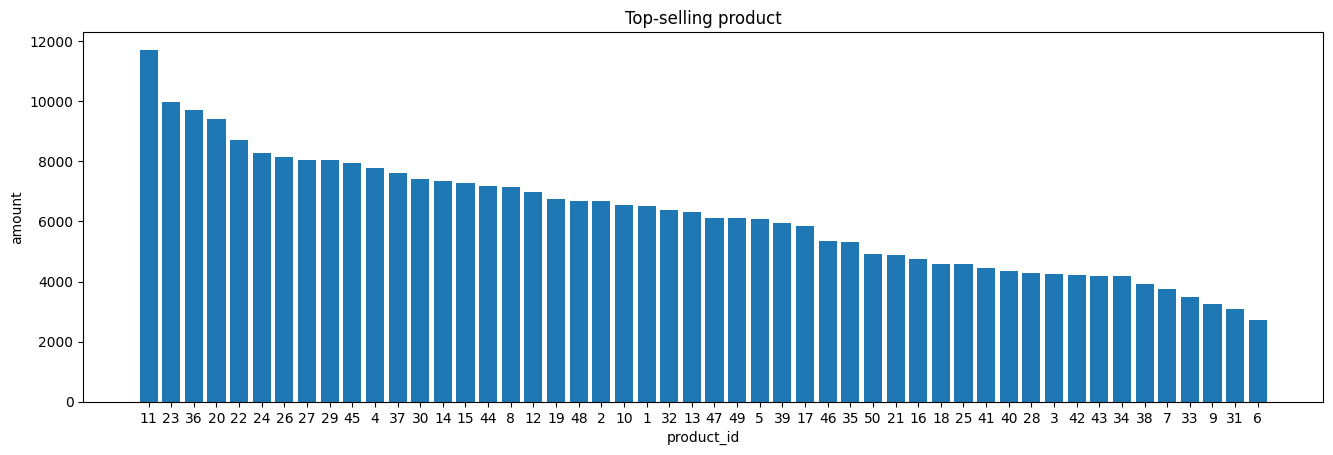

top-selling product_id is 11


In [14]:
# Top customers
sales_per_customer.sort_values(ascending=False, inplace=True)
plt.bar(sales_per_customer.index.astype(str), sales_per_customer)  # Plot the chart
plt.xlabel('customer id')
plt.ylabel('amount')
plt.title('Top customers')
plt.savefig(reports_path + "Top customers") # save as png
plt.show()  # display
print(f"top customer_id is {sales_per_customer.index[0]}")

# Top-selling product
sales_per_prod = customer_sales_df.groupby("product_id")["amount"].sum()
sales_per_prod.sort_values(ascending=False, inplace=True)

plt.figure().set_figwidth(16)
plt.bar(sales_per_prod.index.astype(str), sales_per_prod)  # Plot the chart
plt.xlabel('product_id')
plt.ylabel('amount')
plt.title('Top-selling product')
plt.savefig(reports_path + "Top-selling product") # save as png
plt.show()  # display
print(f"top-selling product_id is {sales_per_prod.index[0]}")

## Analyze sales trends over time (e.g., monthly or quarterly sales).

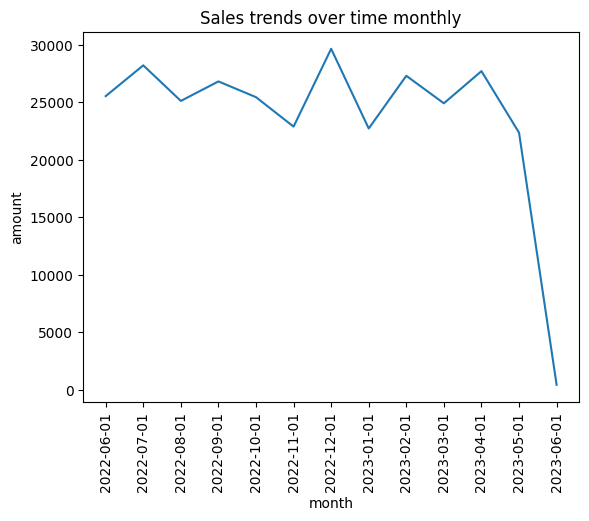

In [15]:
customer_sales_df["month"] = customer_sales_df["order_date"].to_numpy().astype('datetime64[M]') # Extract the frist day of the month from order-date
sales_per_month_df = customer_sales_df.sort_values(by="month").groupby("month")["amount"].sum()

# plt.figure().set_figwidth(8)
plt.plot(sales_per_month_df.index.astype(str), sales_per_month_df)  # Plot the chart
plt.xticks(rotation=90)
plt.xlabel('month')
plt.ylabel('amount')
plt.title('Sales trends over time monthly')
plt.savefig(reports_path + "Sales trends over time monthly") # save as png
plt.show()  # display

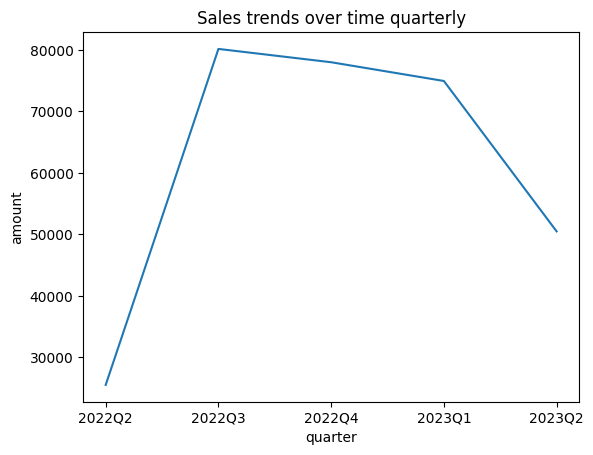

In [16]:
customer_sales_df["quarter"] = pd.PeriodIndex(customer_sales_df['order_date'], freq='Q') # Extract the quarter from order-date
sales_per_quarter_df = customer_sales_df.sort_values(by="quarter").groupby("quarter")["amount"].sum()

plt.plot(sales_per_quarter_df.index.astype(str), sales_per_quarter_df)  # Plot the chart
plt.xlabel('quarter')
plt.ylabel('amount')
plt.title('Sales trends over time quarterly')
plt.savefig(reports_path + "Sales trends over time quarterly") # save as png
plt.show()  # display

## Include weather data in the analysis (e.g., average sales amount per weather condition)

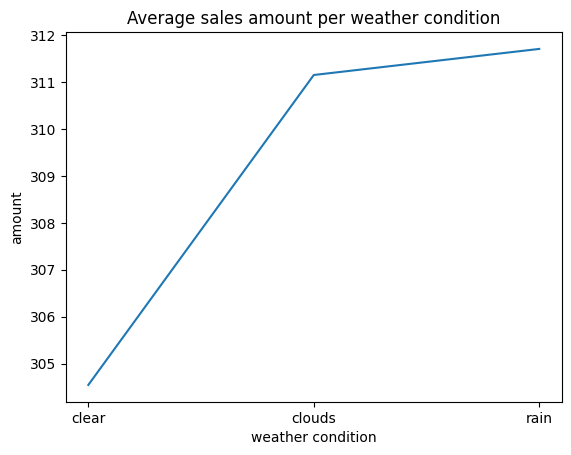

In [17]:
sales_per_weather_df = customer_sales_df.groupby("weather_condition")["amount"].mean()

# plt.figure().set_figwidth(8)
plt.plot(sales_per_weather_df.index.astype(str), sales_per_weather_df)  # Plot the chart
plt.xlabel('weather condition')
plt.ylabel('amount')
plt.title('Average sales amount per weather condition')
plt.savefig(reports_path + "Average sales amount per weather condition") # save as png
plt.show()  # display